In [2]:
from __future__ import print_function
import os
import cv2
import numpy as np
import csv
from PIL import Image
from matplotlib import pyplot as plt

#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVC
from sklearn.decomposition import PCA

#from sklearn.metrics import accuracy_score
from math import hypot

import numba
from numba import jit, cuda 

from keras.utils import to_categorical
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.regularizers import l2


Using TensorFlow backend.


In [3]:
def edit_csvfiles(directory):
    inputfile = csv.reader(open(directory + '\\DefectResult.csv','r'))
    outputfile = open(directory + '\\DefectResult_edited.csv','w')

    line = 0
    for row in inputfile:
        #print("Line", line)
        for i in range(0, len(row)):
            #print(row[i])
            if i == 5 and line == 0 and row[i] == "Bottom":
                #print("CSV file is normal")
                outputfile.write(row[i])
                continue
            elif i == 5 and line == 0:
                #print(row[i])
                #print("writing Bottom")
                attributes = row[i].replace('Bottom','Bottom\n')
                outputfile.write(attributes)
                outputfile.write(",")
            elif i < len(row)-1:
                outputfile.write(row[i])
                outputfile.write(",")
            elif i == len(row)-1:
                outputfile.write(row[i])
        outputfile.write("\n")
        line +=1


#ex = os.getcwd() + "\AllLenses" + "\\Allframedata1" + "\\00000012"
#edit_csvfiles(ex)


In [4]:
@jit
def old_mask(img):
    bad = False
    #img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    #                 CROP
    x_start = 50
    y_start = 50
    crop_img = img[y_start:y_start+1255, x_start:x_start+1250]
    #                 RESIZE CROPPED
    scale_percent = 100 #was 50. can't detect circles at 25%
    width = int(crop_img.shape[1] * scale_percent / 100)
    height = int(crop_img.shape[0] * scale_percent / 100)
    dsize = (width, height)
    img = cv2.resize(crop_img, dsize)

    img = cv2.medianBlur(img,5)
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    #print("Hough Circles")
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 400, param1=50, param2=25, minRadius=150, maxRadius=0)
    #print("Houghed")
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)


    #print("width, height", width, height)
    x, y, r = circles[0,:][0]
    
    if x<width*0.35 or x > width*0.65 or y<height*0.35 or y > height*0.65:
        print("x,y:",x,y)
        bad = True
        plt.imshow(cimg, cmap = 'gray', interpolation = 'bicubic')
        plt.show()
        
    rows, cols = img.shape

    for i in range(cols):
        for j in range(rows):
            if hypot(i-x, j-y) > r:
                img[j,i] = 0
                
    #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    #plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    #plt.show()
    
    return img, bad


In [5]:
@jit
def load_images_from_folder(folder, key):
    listofFiles = os.listdir(folder)
    for filename in listofFiles:
        joinedFilePath = os.path.join(folder,filename)
        if key =="RGB":
            img = cv2.imread(joinedFilePath)
        elif key == "Grayscale":
            img = cv2.imread(joinedFilePath, 0)
        if img is not None and filename == "PRT_000001_L1.jpg":
            #print("masking")
            #img, bad = old_mask(img)
            bad = False
            print("Loaded image from", folder)
            
            return img, bad

#ex = os.getcwd() + "\AllLenses" + "\\Allframedata4" + "\\00000128"
#load_images_from_folder(ex, "Grayscale")

In [6]:
def rotate(image, angle, scale=1.0):
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv2.warpAffine(image,M,(w,h))
        return image

In [7]:
def flip(image, vflip, hflip):
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 

In [8]:
def get_labels(folder):
    defect = "불량" #1
    redef = "반응불량"
    reserved = "보류" #2
    normal = "정상" #0
    target = folder + "\\" + 'DefectResult_edited.csv'
    label = "N/A"
    
    if os.path.exists(target):
        with open(target) as fin:
            reader = csv.reader(fin)
            next(reader)
            for row in reader:
                #print(row)
                if defect in row[1:2]: #looks for 반응불량 only   , redef in row[0:1] and 
                    label = 1 # 2 to 1
                    break
                elif reserved in row or defect in row[1:2]:
                    label = 2 #1 to 2
                elif normal in row:
                    label = 0         
    else:
        print("DefectResult_edited.csv was not found in ", folder)

    return label

#ex = os.getcwd() + "\AllLenses" + "\\Allframedata4" + "\\00000106"
#get_labels(ex)

In [9]:
@jit
def getImagesandLabels(path, folders):

    images = []
    labels = []
    folder= path

    for i in range(0, len(folders)):
        folder= path + "\\" + folders[i]
        edit_csvfiles(folder) #run once only
        result, bad = load_images_from_folder(folder, "Grayscale") #choose "RGB" or "Grayscale"
        the_label = get_labels(folder)
        """
        if (the_label == 2):
            print("skipping 보류")
            continue"""
            
        if (bad ==True):
            print("BAD IMAGE")
            continue
            
        if the_label == 1:
            plt.imshow(result, cmap='gray')
            plt.show()
            # Filename 
            filename = str(i) + '.jpg'

            # Using cv2.imwrite() method 
            # Saving the image 
            cv2.imwrite(filename, result)
            
        print("Label:", the_label)
        
        images.append(result)
        labels.append(the_label)
        
        if the_label == 2:            
            images.append(rotate(result, angle=90, scale=1.0))
            labels.append(the_label)

            images.append(rotate(result, angle=180, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=270, scale=1.0))
            labels.append(the_label)
            
        if the_label == 1:
            images.append(rotate(result, angle=11.25, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=22.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=33.75, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=45, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=56.25, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=67.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=78.75, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=90, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=101.25, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=112.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=123.75, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=135, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=146.25, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=157.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=168.75, scale=1.0))
            labels.append(the_label)

            images.append(rotate(result, angle=180, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=191.25, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=202.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=213.75, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=225, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=236.25, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=247.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=258.75, scale=1.0))
            labels.append(the_label)

            images.append(rotate(result, angle=270, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=281.25, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=292.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=303.75, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=315, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=326.25, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=337.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=348.75, scale=1.0))
            labels.append(the_label)
            
            images.append(flip(result, vflip=True, hflip=False))
            labels.append(the_label)

            images.append(flip(result, vflip=False, hflip=True))
            labels.append(the_label)
        
        elif the_label==0:
            '''
            images.append(rotate(result, angle=90, scale=1.0))
            labels.append(the_label)

            images.append(rotate(result, angle=180, scale=1.0))
            labels.append(the_label)
            images.append(rotate(result, angle=270, scale=1.0))
            labels.append(the_label)'''
            
            images.append(flip(result, vflip=True, hflip=False))
            labels.append(the_label)

            images.append(flip(result, vflip=False, hflip=True))
            labels.append(the_label)
            #zooming?
    return images, labels

In [11]:
@jit
def preprocess_XY(images, labels):
    print("############# OVERALL ################")
    defectcount = reservedcount = normalcount = 0
    for element in labels:
        if element == 1:
            defectcount +=1
        elif element == 2:
            reservedcount+=1
        elif element == 0:
            normalcount +=1
    print("불량 갯수:", defectcount)
    print("보류 갯수:", reservedcount)
    print("정상 갯수:", normalcount)
    defe = "{:.2f}".format((defectcount/len(labels))*100)
    print("불량 비율:", defe)
    rese = "{:.2f}".format((reservedcount/len(labels))*100)
    print("보류 비율:", rese)
    norm = "{:.2f}".format((normalcount/len(labels))*100)
    print("정상 비율:", norm)
    print()
    
    images = np.asarray(images)
    labels = np.asarray(labels)
    
    splitter =int(len(images)*.75)
    x_train = images[0:splitter]
    x_test = images[splitter:len(images)]
    y_train = labels[0:splitter]
    y_test = labels[splitter:len(labels)]
    
    class_names = ["Normal", "Defect"]
    fig = plt.figure(figsize=(30,30))
    fig.patch.set_facecolor('white')

    h = 0
    defc= 0
    print("불량 모음")
    while defc < 50 and h<100:
        #print("h:",h)
        if y_train[h] == 1:
            defc+=1
            plt.subplot(10,10,h+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(x_train[h], cmap='gray')
            plt.xlabel(class_names[y_train[h]])
        h+=1
    plt.show()
    
    mult = images[0].shape[0] * images[0].shape[1]
    print("n pixels:", mult)

    x_train = x_train.reshape(len(x_train), mult)
    x_test = x_test.reshape(len(x_test), mult)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = x_train / 255.0*100#-50?
    x_test = x_test / 255.0*100#-50?
    #y_train = y_train % 2
    #y_test = y_test % 2
    
    pca = PCA(n_components=70)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)

    y_train = to_categorical(y_train, num_classes = 2) #change 
    y_test = to_categorical(y_test, num_classes = 2) #change
    
    
    return x_train, y_train, x_test, y_test

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2592      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 2,658
Trainable params: 2,658
Non-trainable params: 0
_________________________________________________________________
Files and Directories in 'C:\Users\main\AllLenses\Allframedata1'


<ipython-input-9-107627632699>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "getImagesandLabels" failed type inference due to: Untyped global name 'edit_csvfiles': Cannot determine Numba type of <class 'function'>

File "<ipython-input-9-107627632699>", line 10:
def getImagesandLabels(path, folders):
    <source elided>
        folder= path + "\\" + folders[i]
        edit_csvfiles(folder) #run once only
        ^

  @jit
<ipython-input-9-107627632699>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "getImagesandLabels" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-9-107627632699>", line 8:
def getImagesandLabels(path, folders):
    <source elided>

    for i in range(0, len(folders)):
    ^

  @jit
C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\numba\core\object_mode_passes.py:151: Num

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000000
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000001
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000002
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000003
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000004
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000005
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000006
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000007
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000008
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000009
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000010
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000011
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000012
Label: 0
Loaded image from C:\Users\main\AllLen

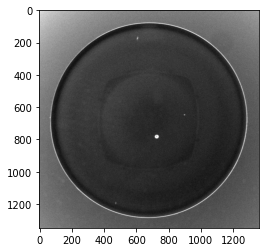

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000014
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000015
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000016
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000017
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000018
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000019
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000020
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000021
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000022
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000023
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000024
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000025
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000026
Label: 0
Loaded image from C:\Users\ma

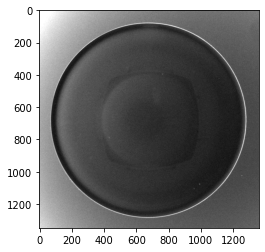

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000028
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000030
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000031
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000032
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000033
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000035
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000036
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000038
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000039
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000040
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000041
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000042
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000043
Label: 2
Loaded image from C:\Users\ma

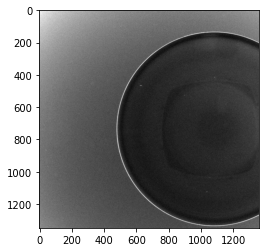

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000073
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000074


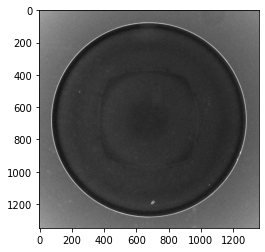

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000075
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000076
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000077
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000078
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000079
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000081
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000082
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000083
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000084
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000085
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000086
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000087
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000088
Label: 2
Loaded image from C:\Users\ma

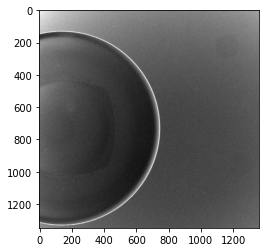

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000104
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000105
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000106
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000107
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000108
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000109
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000110
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000111
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000112
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000113
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000114
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000115
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000116
Label: 2
Loaded image from C:\Users\ma

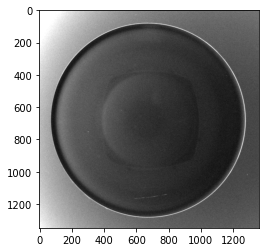

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000120
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000121
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000122


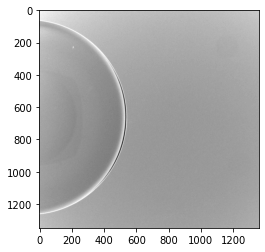

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000123
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000124


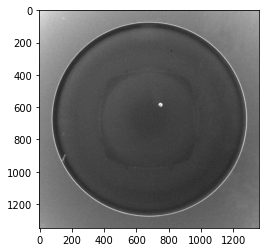

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000125
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000126
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000127
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000128
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000129
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000130
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000131
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000132
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000133
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000134
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000135
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000136
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000137
Label: 2
Loaded image from C:\Users\ma

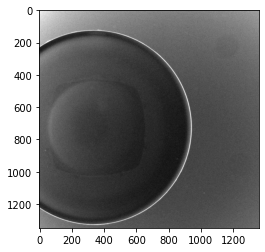

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000158
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000159


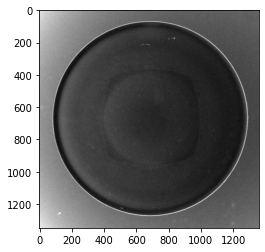

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000160
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000161
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000162
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000163
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000164
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000165
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000166
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000167


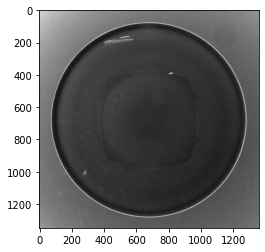

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000168
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000169
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000170
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000171
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000172
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000173
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000174
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000175
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000176
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000177
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000178
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000179
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000180
Label: 2
Loaded image from C:\Users\ma

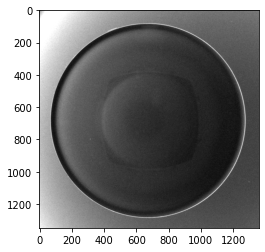

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000198
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000199
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000200
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000201


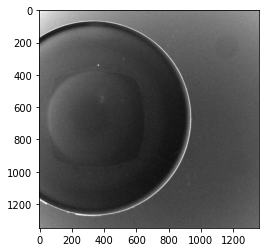

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000202
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000203
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000204
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000205
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000206
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000207
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000208
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000209
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000210
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000211
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000212
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000213
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000214
Label: 2
Loaded image from C:\Users\ma

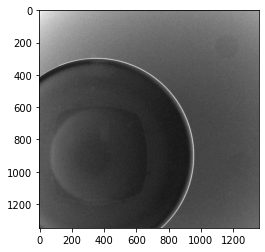

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000225


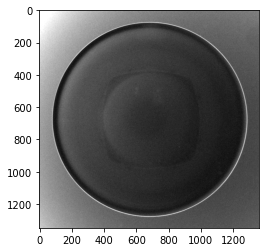

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000226
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000227
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000228
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000229


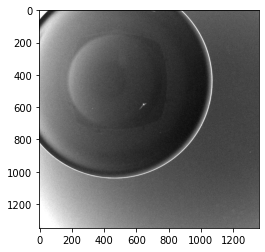

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000230
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000231
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000232
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000233
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000234
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000235
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000236
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000237


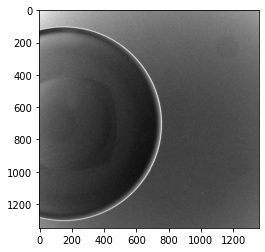

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000238
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000239
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000240
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000241


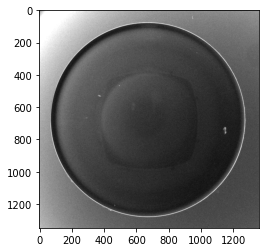

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000242
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000243
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000244


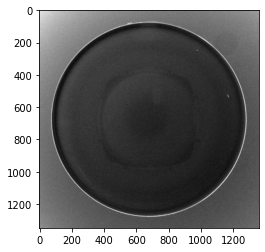

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000245


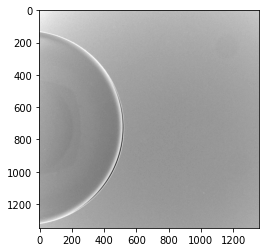

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000246
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000247
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000248
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000249
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000250
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000251
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000252
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000253
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000254
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000255
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000256
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000257


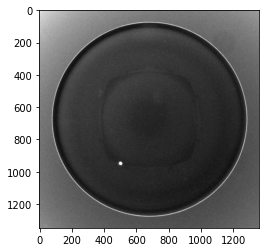

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000258
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000259
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000260
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000261


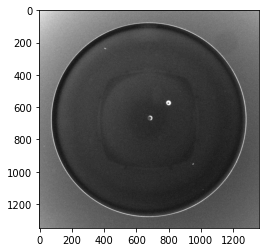

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000262
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000263


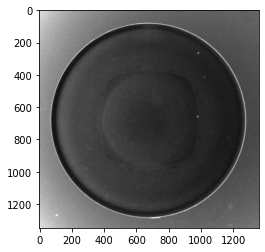

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000264
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000265
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000266
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000267
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000268
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000269
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000270
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000271
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000272
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000273
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000274
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000275


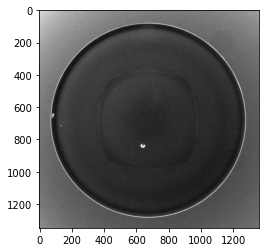

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000276
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000277
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000278
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000279
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000280
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000281
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000282
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000283
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000284
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000286
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000287
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000288
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000289
Label: 2
Loaded image from C:\Users\ma

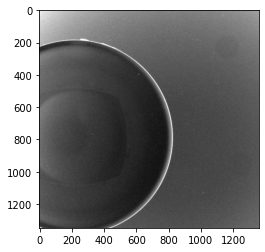

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000300
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000301
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000302
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000304
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000305
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000306
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000307
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000309
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000310
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000311
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000312
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000313
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000314
Label: 2
Loaded image from C:\Users\ma

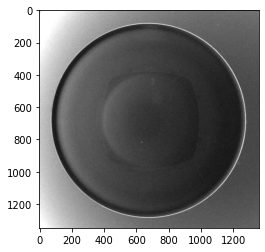

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000318
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000319
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000320
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000321
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000322
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000323
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000324
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000325
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000326
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000327
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000328
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000329
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000330
Label: 0
Loaded image from C:\Users\ma

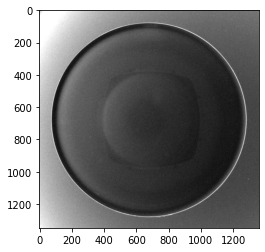

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000338
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000339
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000340
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000341


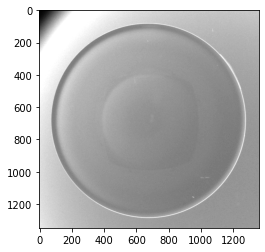

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000342
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000343
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000344
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000345
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000346
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000347
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000348
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000349
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000350
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000351
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000352
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000354
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000355
Label: 0
Loaded image from C:\Users\ma

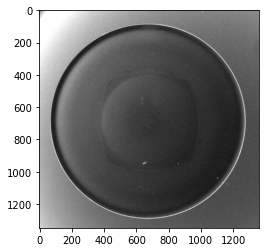

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000380
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000381
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000382
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000383
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000384
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000385
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000386
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000387
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000388
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000389
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000390
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000391
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000392
Label: 2
Loaded image from C:\Users\ma

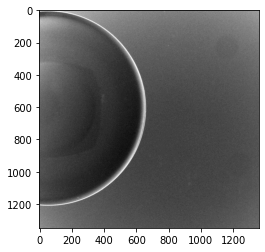

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000396
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000397
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000398
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000400
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000401
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000402
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000403
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000404
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000405
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000406
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000407
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000408
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000409
Label: 2
Loaded image from C:\Users\ma

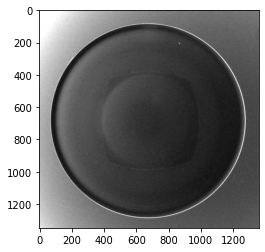

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000431
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000432
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000433
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000435
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000436
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000437
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000438
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000439
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000441
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000442
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000443
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000444
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000445
Label: 0
Loaded image from C:\Users\ma

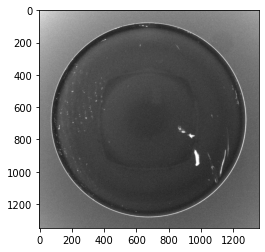

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000452


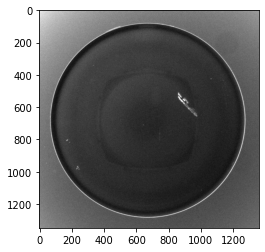

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000453
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000454
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000455
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000457
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000458
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000459
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000460
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000461
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000463
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000464
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000465
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000466
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000467
Label: 2
Loaded image from C:\Users\ma

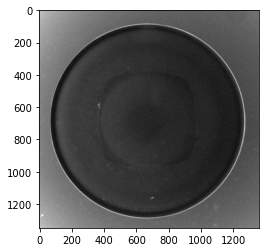

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000476


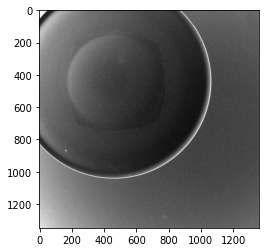

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000477
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000478
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000479
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000480
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000481


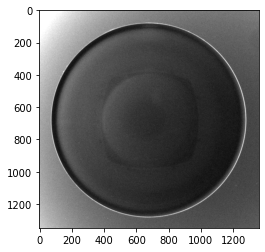

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000482
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000483
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000484
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000485
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000486
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000487
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000488
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000490


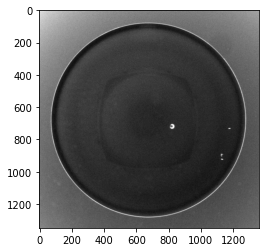

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000491
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000492
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000493
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000494
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000495
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000496


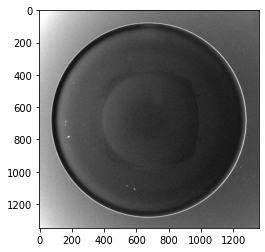

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000497
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000498
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000499
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000500
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000501
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000502
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000503
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000504
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000505
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000506
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000507
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000508
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000509
Label: 2
Loaded image from C:\Users\ma

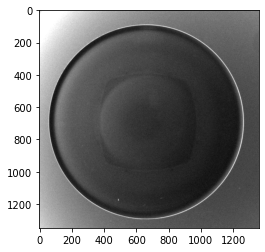

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000521
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000522
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000523


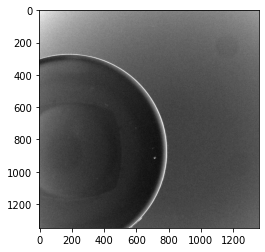

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000524
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000525
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000526
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000527
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000528


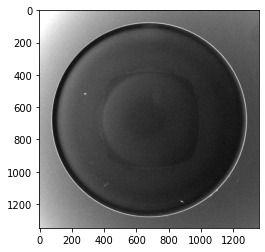

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000529
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000530
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000531
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000532
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000533
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000534
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000535
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000536
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000537
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000538
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000539
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000540
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000541
Label: 2
Loaded image from C:\Users\ma

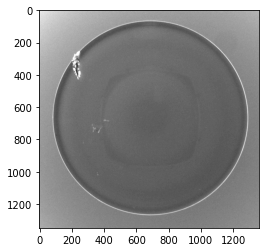

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000545
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000546
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000547
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000548
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000549
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000550
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000551
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000553
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000554


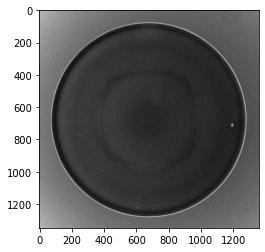

Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000555
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000556
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000557
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000558
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000559
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000560
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000561
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000562
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000563
Label: 2
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000564
Label: 2


In [12]:
num_classes = 2 #change appropriately
model = Sequential()
model.add(Dense(32, kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1), activation='relu', input_shape=(80,)))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation="sigmoid")) #sigmoid if binary

model.summary()
#momentum .5, .9, and .99, , momentum = 0.99
opt=tensorflow.keras.optimizers.Adagrad(lr=0.005) #SGD has too high of loss
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
#loss='binary_crossentropy' vs categorical_crossentropy

directory = os.getcwd() + "\AllLenses"


path_list =[]

path_list.append(directory + "\Allframedata1")
#path_list.append(directory + "\Allframedata2")
#path_list.append(directory + "\Allframedata3")#bad lot
#path_list.append(directory + "\Allframedata4")
#path_list.append(directory + "\Allframedata5")
#path_list.append(directory + "\Allframedata6")

for path in path_list:
    folders = []
    subject_folder = os.scandir(path)
    print("Files and Directories in '% s'" % path) 

    for file in subject_folder: 
        if file.is_dir() or file.is_file(): #중간중간에 파일이 빠져있음
            folders.append(file.name)
            #print("There is folder:", file.name)

    x, y = getImagesandLabels(path, folders)
    """
    
    print("# of images", len(x))
    print("# of labels", len(y))
    
    #datagen.fit(x)
    #for X_batch, Y_batch in datagen.flow(tuple_input, y, batch_size=25): # these are chunks of 32 samples
    X_train, Y_train, X_test, Y_test = preprocess_XY(x, y) 
    #print("Y_train:", Y_train)
    #print("Y_test:", Y_test)
    history = model.fit(X_train, Y_train, epochs=400, batch_size=32, verbose=1,validation_data=(X_test, Y_test))

    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','val'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','val'], loc='upper left')
    plt.show()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])"""

In [ ]:
X_train, Y_train, X_test, Y_test = preprocess_XY(x, y)

<ipython-input-11-1dd6c9ee7b74>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "preprocess_XY" failed type inference due to: Untyped global name 'to_categorical': Cannot determine Numba type of <class 'function'>

File "<ipython-input-11-1dd6c9ee7b74>", line 68:
def preprocess_XY(images, labels):
    <source elided>

    y_train = to_categorical(y_train, num_classes = 2) #change 
    ^

  @jit
<ipython-input-11-1dd6c9ee7b74>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "preprocess_XY" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-11-1dd6c9ee7b74>", line 5:
def preprocess_XY(images, labels):
    <source elided>
    defectcount = reservedcount = normalcount = 0
    for element in labels:
    ^

  @jit
C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\numba\core\object_mode_passes.py:151: Nu

############# OVERALL ################


C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\numba\core\ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'labels' of function 'preprocess_XY'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-11-1dd6c9ee7b74>", line 5:
def preprocess_XY(images, labels):
    <source elided>
    defectcount = reservedcount = normalcount = 0
    for element in labels:
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


불량 갯수: 1462
보류 갯수: 1384
정상 갯수: 468
불량 비율: 44.12
보류 비율: 41.76
정상 비율: 14.12



In [ ]:
print(history.history.keys())

In [ ]:
model.save(os.getcwd()+"\MLP model 90 acc 3 lots")

In [18]:
from tensorflow.keras.models import load_model
new_model = load_model(os.getcwd()+"\MLP model 90 acc 3 lots", custom_objects=None, compile=True)

In [19]:
score = new_model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: in user code:

    C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1233 test_function  *
        return step_function(self, iterator)
    C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1217 run_step  **
        outputs = model.test_step(data)
    C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1183 test_step
        y_pred = self(x, training=False)
    C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 70 but received input with shape (None, 80)


In [20]:
@jit
def get_samples(path, folders):
    images = []
    labels = []
    folder= path

    for i in range(0, len(folders)):
        folder= path + "\\" + folders[i]
        result, bad = load_images_from_folder(folder, "Grayscale") #choose "RGB" or "Grayscale"
        the_label = get_labels(folder)
        if (the_label == 2):
            continue
        if (bad ==True):
            print("BAD IMAGE")
            continue
        images.append(result)
        labels.append(the_label)
    
    return images, labels

@jit
def preprocess_sample(samples, labels):
    print("############# OVERALL ################")
    defectcount = reservedcount = normalcount = 0
    for element in labels:
        if element == 1:
            defectcount +=1
        elif element == 2:
            reservedcount+=1
        elif element == 0:
            normalcount +=1
    print("불량 갯수:", defectcount)
    print("보류 갯수:", reservedcount)
    print("정상 갯수:", normalcount)
    print()
    
    samples = np.asarray(samples)
    nplabels = np.asarray(labels)
    mult = samples[0].shape[0] * samples[0].shape[1]
    print("n pixels:", mult)

    samples = samples.reshape(len(samples), mult)
    samples = samples.astype('float32')
    samples = samples / 255.0*100
    
    pca = PCA(n_components=70)
    samples = pca.fit_transform(samples)
    nplabels = to_categorical(nplabels, num_classes = 2)
    
    return samples, nplabels

In [31]:
path0 = directory + "\Allframedata5"

folders0 = []
subject_folder = os.scandir(path0)
print("Files and Directories in '% s'" % path0) 
count = 0
for file in subject_folder:
    if (count < 100):
        if file.is_dir() or file.is_file(): #중간중간에 파일이 빠져있음
            folders0.append(file.name)
            #print("There is folder:", file.name)
    count+=1


samples, slabels = get_samples(path0, folders0) #amounts has been limited to 'count'


Files and Directories in 'C:\Users\main\AllLenses\Allframedata5'
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000000
['반응불량', '보류', ' 283', '983', '300', '996']
['반응불량', '보류', ' 420', '1092', '425', '1143']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000001
['반응불량', '보류', ' 875', '211', '890', '226']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000002
['반응불량', '보류', ' 565', '1161', '580', '1180']
['반응불량', '보류', ' 681', '1171', '700', '1194']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000003
['이물불량', '보류', ' 1111', '476', '1122', '505']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000004
['반응불량', '보류', ' 790', '491', '797', '508']
['반응불량', '보류', ' 775', '472', '794', '504']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000005
['반응불량', '보류', ' 103', '721', '204', '792']
['반응불량', '보류', ' 247', '763', '266', '778']
['반응불량', '보류', ' 865', '201', '880', '216']
['이물불량', '불량', ' 195', '725', '282', '

Loaded image from C:\Users\main\AllLenses\Allframedata5\00000048
['반응불량', '보류', ' 319', '1039', '338', '1054']
['반응불량', '보류', ' 611', '741', '632', '756']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000049
['반응불량', '보류', ' 409', '237', '422', '256']
['반응불량', '보류', ' 598', '307', '654', '342']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000050
['정상', '정상', '0', '0', '0', '0']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000051
['정상', '정상', '0', '0', '0', '0']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000052
['정상', '정상', '0', '0', '0', '0']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000053
['엣지불량', '보류', ' 93', '456', '136', '498']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000054
['반응불량', '보류', ' 227', '671', '246', '688']
['반응불량', '보류', ' 493', '951', '510', '964']
['반응불량', '보류', ' 515', '837', '534', '854']
['반응불량', '보류', ' 895', '145', '924', '174']
['반응불량', '보류', ' 677', '860', '

Loaded image from C:\Users\main\AllLenses\Allframedata5\00000103
['엣지불량', '불량', ' 128', '964', '210', '1051']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000104
['반응불량', '보류', ' 483', '243', '496', '252']
['기포불량', '불량', ' 615', '675', '634', '693']
['반응불량', '보류', ' 609', '648', '639', '685']
['엣지불량', '보류', ' 83', '497', '122', '525']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000105
['엣지불량', '보류', ' 1260', '722', '1295', '746']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000106
['정상', '정상', '0', '0', '0', '0']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000107
['정상', '정상', '0', '0', '0', '0']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000108
['반응불량', '보류', ' 177', '813', '196', '826']
['반응불량', '보류', ' 1139', '829', '1230', '910']
['반응불량', '보류', ' 795', '534', '816', '556']
[]
Loaded image from C:\Users\main\AllLenses\Allframedata5\00000109
['반응불량', '보류', ' 615', '727', '646', '758']
[]


In [32]:
print("number of samples",len(samples))
pred_ready_x, pred_ready_y = preprocess_sample(samples, slabels)

number of samples 20
############# OVERALL ################
불량 갯수: 2
보류 갯수: 0
정상 갯수: 18

n pixels: 391875


ValueError: n_components=70 must be between 0 and min(n_samples, n_features)=20 with svd_solver='full'

In [24]:
new_model = load_model(os.getcwd()+"\MLP model 90 acc 3 lots", custom_objects=None, compile=True)
score = new_model.evaluate(pred_ready_x, pred_ready_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6522267460823059
Test accuracy: 0.8269230723381042


In [28]:
predictions = model.predict(pred_ready_x)

count =0 
current = 2
for pred in predictions:
    #print(max(pred[0],pred[1]))
    if (pred[0] > pred[1]):
        current = 0
        print("정상")
    elif(pred[0] < pred[1]):
        current = 1
        print("불량")

    #print("Predicted:")
    #print(current)
    print()
    count+=1 

불량

불량

불량

불량

불량

불량

불량

불량

불량

불량

불량

정상

불량

정상

불량

불량

불량

불량

정상

정상

불량

불량

불량

불량

정상

불량

정상

정상

불량

불량

불량

불량

정상

불량

정상

불량

불량

불량

정상

정상

불량

정상

불량

정상

정상

불량

불량

정상

불량

불량

정상

불량

정상

불량

불량

정상

불량

불량

불량

정상

정상

불량

불량

불량

정상

정상

불량

불량

불량

정상

정상

정상

불량

정상

불량

불량

불량

불량

불량

불량

불량

불량

불량

정상

정상

정상

불량

불량

불량

불량

정상

불량

정상

정상

불량

정상

불량

불량

불량

불량

불량

정상

불량

불량

